<a id="inicio"></a>
<img src="http://www.cidaen.es/assets/img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">




<br><br><br>
<h2><font color="#00586D" size=4>Capstone V (1)</font></h2>

<h1><font color="#00586D" size=5>Análisis y predicción de un conjunto de datos sobre precios de viviendas</font></h1>
<br><br><br>


<div align="right">
<font color="#00586D" size=3>&copy; Luis de la Ossa</font><br>
<font color="#00586D" size=3>Máster en Ciencia de Datos e Ingeniería de Datos en la Nube</font><br>
<font color="#00586D" size=3>Universidad de Castilla-La Mancha</font>

</div>
<br>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import numpy as np
import pandas as pd

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

<a id="indice"></a>
<h2><font color="#00586D" size=5>Índice</font></h2>

#### <font color="#00586D"> Notebook I</font>
* [1. Introducción](#section1)
* [2. Preparación de los datos](#section2)
* [3. Exploración preliminar](#section3)

#### <font color="#00586D"> Notebook II</font>
* [4. Predicción con modelos básicos](#section4)
* [5. Ensembles](#section5)
* [6. Explicabilidad](#section6)
* [7. KNN](#section7)
* [8. Construcción de características](#section8)
* [9. Descarte de outliers](#section9)
* [10. Aprendizaje no supervisado: PCA y EM](#section10)


---

<a id="section1"></a>
## <font color="#00586D"> 1. Introducción</font>
<br>

En este proyecto se abordará un problema de análisis y predicción de precios de viviendas. El conjunto de datos original se ha obtenido de [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data), y es la base de un concurso que, a día de hoy, sigue abierto (aunque sin premio). Como se puede leer en la descripción del reto, este problema es adecuado para trabajar en la creación de características o el uso de ensembles. En este proyecto  abordaremos estas tareas, además de otras. 

Por último, a pesar de que en la web se pueden descargar un conjunto de entrenamiento y otro de test, éste último no está etiquetado. Por tanto se utilizará solamente el conjunto de entrenamiento y validación cruzada. No obstante, un ejercicio interesante consistiría en ampliar el proyecto y someter la predicción del test para comparar con otros resultados. También es muy interesante echar un vistazo a trabajos que ha hecho la gente con este mismo conjunto de datos, y que están disponibles en Kaggle.


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>  Esta primera libreta sólamente contiene la descripción del proceso de preparación de los datos. Por tanto, se trata solamente de leerla, ya que **no contiene ningún ejercicio.**
</div>


El archivo `data/houses.csv` contiene los datos con los que se trabajará. Como puede observarse tras una inspección previa, los valores perdidos se codifican con la etiqueta `NA`, aunque este punto se tratará con más detalle posteriormente.

In [2]:
df_houses = pd.read_csv('data/houses.csv', index_col=0, na_values='NA')
#df_houses.info()
df_houses.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1234,20,RL,NaN,12160,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,5,2010,COD,Abnorml,142000
912,20,RL,NaN,9286,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,143500
1187,190,RL,107.0,10615,Pave,NaN,IR1,Bnk,AllPub,Corner,...,0,NaN,NaN,NaN,0,8,2009,WD,Abnorml,95000
878,60,RL,74.0,8834,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,350000
331,90,RL,NaN,10624,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,11,2007,WD,Normal,119000


---

<a id="section2"></a>
## <font color="#00586D"> 2. Preparación</font>


### <font color="#00586D">Tipos de datos</font>


Puede observarse que el conjunto de datos representa cada vivienda mediante 80 características cuya descripción puede encontrarse en el archivo `data/data_description.txt`. Esta información es interesante también de cara a determinar con qué tipo de datos se ha de representar cada una de ellas y, en algunos casos, qué valores pueden tomar. 


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> Esta última circunstancia resulta de especial interés, ya que permite simplificar enormemente el *pipeline* de transformación, y dedicar el trabajo a la construcción de los modelos. No obstante, para procesar los datos de test y someter los resultados, sí que habría que construir un *pipeline*. Ese ejercicio se dejará como opcional. 
</div>


Aunque cada característica se codifica con un tipo de datos, éste puede no corresponderse con el modo en que ha de ser tratada. Por ejemplo, la columna `MSSubClass` representa el tipo de vivienda mediante valores numéricos y, sin embargo, ha de tratarse como discreta. Por otra parte, existen características discretas en las que los posibles valores guardan una relación de orden, y no es conveniente perder esa información: éstas han de ser tratadas como ordinales (codificadas con categorías o con enteros). 

En esta celda se establecen los distintos tipos de características y se lleva a cabo la descripción de los valores ordinales. Este trabajo de inspección (algo árido) se ha llevado a cabo ***manualmente*** a partir de las descripciones proporcionadas en el archivo `data/data_description.txt` (se recomienda echarle un vistazo).

In [3]:
# Características numéricas
numerical = ['LotFrontage', 'LotArea','OverallQual','OverallCond',
             'YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2',
             'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF',
             'GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
             'BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt',
             'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
             '3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold','SalePrice']

# Características categóricas (discretas)
discrete = ['MSSubClass','MSZoning','Street','Alley','LandContour', 'LotConfig',
            'Neighborhood', 'Condition1', 'Condition2','BldgType','HouseStyle',
            'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType',
            'Foundation','Heating','CentralAir','Electrical','GarageType','MiscFeature',
            'SaleType','SaleCondition']

# Características categóricas (ordinales)
ordinal = ['LotShape','Utilities', 'LandSlope','ExterQual','ExterCond','BsmtQual',
           'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC',
           'KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual',
           'GarageCond','PavedDrive','PoolQC','Fence']

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> En el caso de las características ordinales, **es importante mantener la relación de orden de las etiquetas**.
</div>


 Esto implica que, independientemente de cómo y donde se haga la codificación, hay que proporcionar dicho orden. En este caso, se recodificará el *DataFrame* inicial para simplificar el código posterior.

In [4]:
df_houses['LotShape'].replace({'IR3':1,'IR2':2,'IR1':3,'Reg':4}, inplace=True)
df_houses['Utilities'].replace({'ELO':1,'NoSeWa':2,'NoSewr':3,'AllPub':4}, inplace=True)
df_houses['LandSlope'].replace({'Gtl':1,'Mod':2,'Sev':3}, inplace=True)
df_houses['ExterQual'].replace({'Po':1, 'Fa':2,'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df_houses['ExterCond'].replace({'Po':1, 'Fa':2,'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df_houses['BsmtQual'].replace({'Po':1, 'Fa':2,'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df_houses['BsmtCond'].replace({'Po':1, 'Fa':2,'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df_houses['BsmtExposure'].replace({'No':1,'Mn':2,'Av':3, 'Gd':4}, inplace=True)
df_houses['BsmtFinType1'].replace({'Unf':1,'LwQ':2,'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)
df_houses['BsmtFinType2'].replace({'Unf':1,'LwQ':2,'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)
df_houses['HeatingQC'].replace({'Po':1, 'Fa':2,'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df_houses['KitchenQual'].replace({'Po':1, 'Fa':2,'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df_houses['Functional'].replace({'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8}, inplace=True)
df_houses['FireplaceQu'].replace({'Po':1, 'Fa':2,'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df_houses['GarageFinish'].replace({'Unf':1,'RFn':2,'Fin':3}, inplace=True)
df_houses['GarageQual'].replace({'Po':1, 'Fa':2,'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df_houses['GarageCond'].replace({'Po':1, 'Fa':2,'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df_houses['PavedDrive'].replace({'N':1,'P':2,'Y':3}, inplace=True)
df_houses['PoolQC'].replace({'Po':1, 'Fa':2,'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df_houses['Fence'].replace({'MnWw':1,'GdWo':2,'MnPrv':3, 'GdPrv':4}, inplace=True)

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
__Importante__: Aunque todavía no hemos hecho la división en entrenamiento/test, ***no*** estamos incurriendo en errores de codificación o en *data leakage*, ya que estas categorías son predefinidas y, por tanto, **asumimos** que es el formato en que llegarían todos los datos, también los nuevos.
</div>

---

### <font color="#00586D">Valores nulos</font>

El tratamiento de los valores perdidos en este conjunto de datos es especial debido a los distintos tipos de datos, y al uso que se hace del valor `NA` en el archivo original. Aunque el primer vistazo al conjunto de datos muestra que no contiene valores perdidos como tales, sino el símbolo `NA`, y que éste se ha tratado como *NaN*, un vistazo a los tipos de datos muestra que, para algunas características, `NA` **es informativo**. Por ejemplo, en el caso de `PoolQC`, que representa la calidad de la piscina, y que es la columna con más valores perdidos, `NA` representa que no existe piscina, y que `PoolArea` es igual a cero. Aunque se podría prescindir de esta columna `PoolQC` porque `PoolArea` nos proporciona información, podemos codificarla correctamente, de modo que los propios algoritmos determinen si la variable es o no relevante. 

Con el fin de tratar los valores nulos o perdidos, en primer lugar se observarán las columnas donde existen estos valores.

In [5]:
missing_vals = df_houses.isna().sum().sort_values(ascending=False).where(lambda n: n>0).dropna()
missing_vals

PoolQC          1453.0
MiscFeature     1406.0
Alley           1369.0
Fence           1179.0
FireplaceQu      690.0
LotFrontage      259.0
GarageType        81.0
GarageCond        81.0
GarageFinish      81.0
GarageQual        81.0
GarageYrBlt       81.0
BsmtFinType2      38.0
BsmtExposure      38.0
BsmtQual          37.0
BsmtCond          37.0
BsmtFinType1      37.0
MasVnrArea         8.0
MasVnrType         8.0
Electrical         1.0
dtype: float64

Antes de proceder a tratarlos, es necesario que considerar que la aparición o no aparición de un valor aportar información de interés.  La librería `missingno` implementa algunas funciones de utilidad para llevar a cabo una inspección.

In [6]:
#!pip install missingno

import missingno as msno

Mediante la función `msno.matrix()` puede visualizarse la aparición de valores perdidos en el DataFrame. En este caso, se visualizarán solamente las columnas que contienen valores perdidos. A veces, el ordenar alguna columna permite mejorar la visualización (en este caso no mucho).

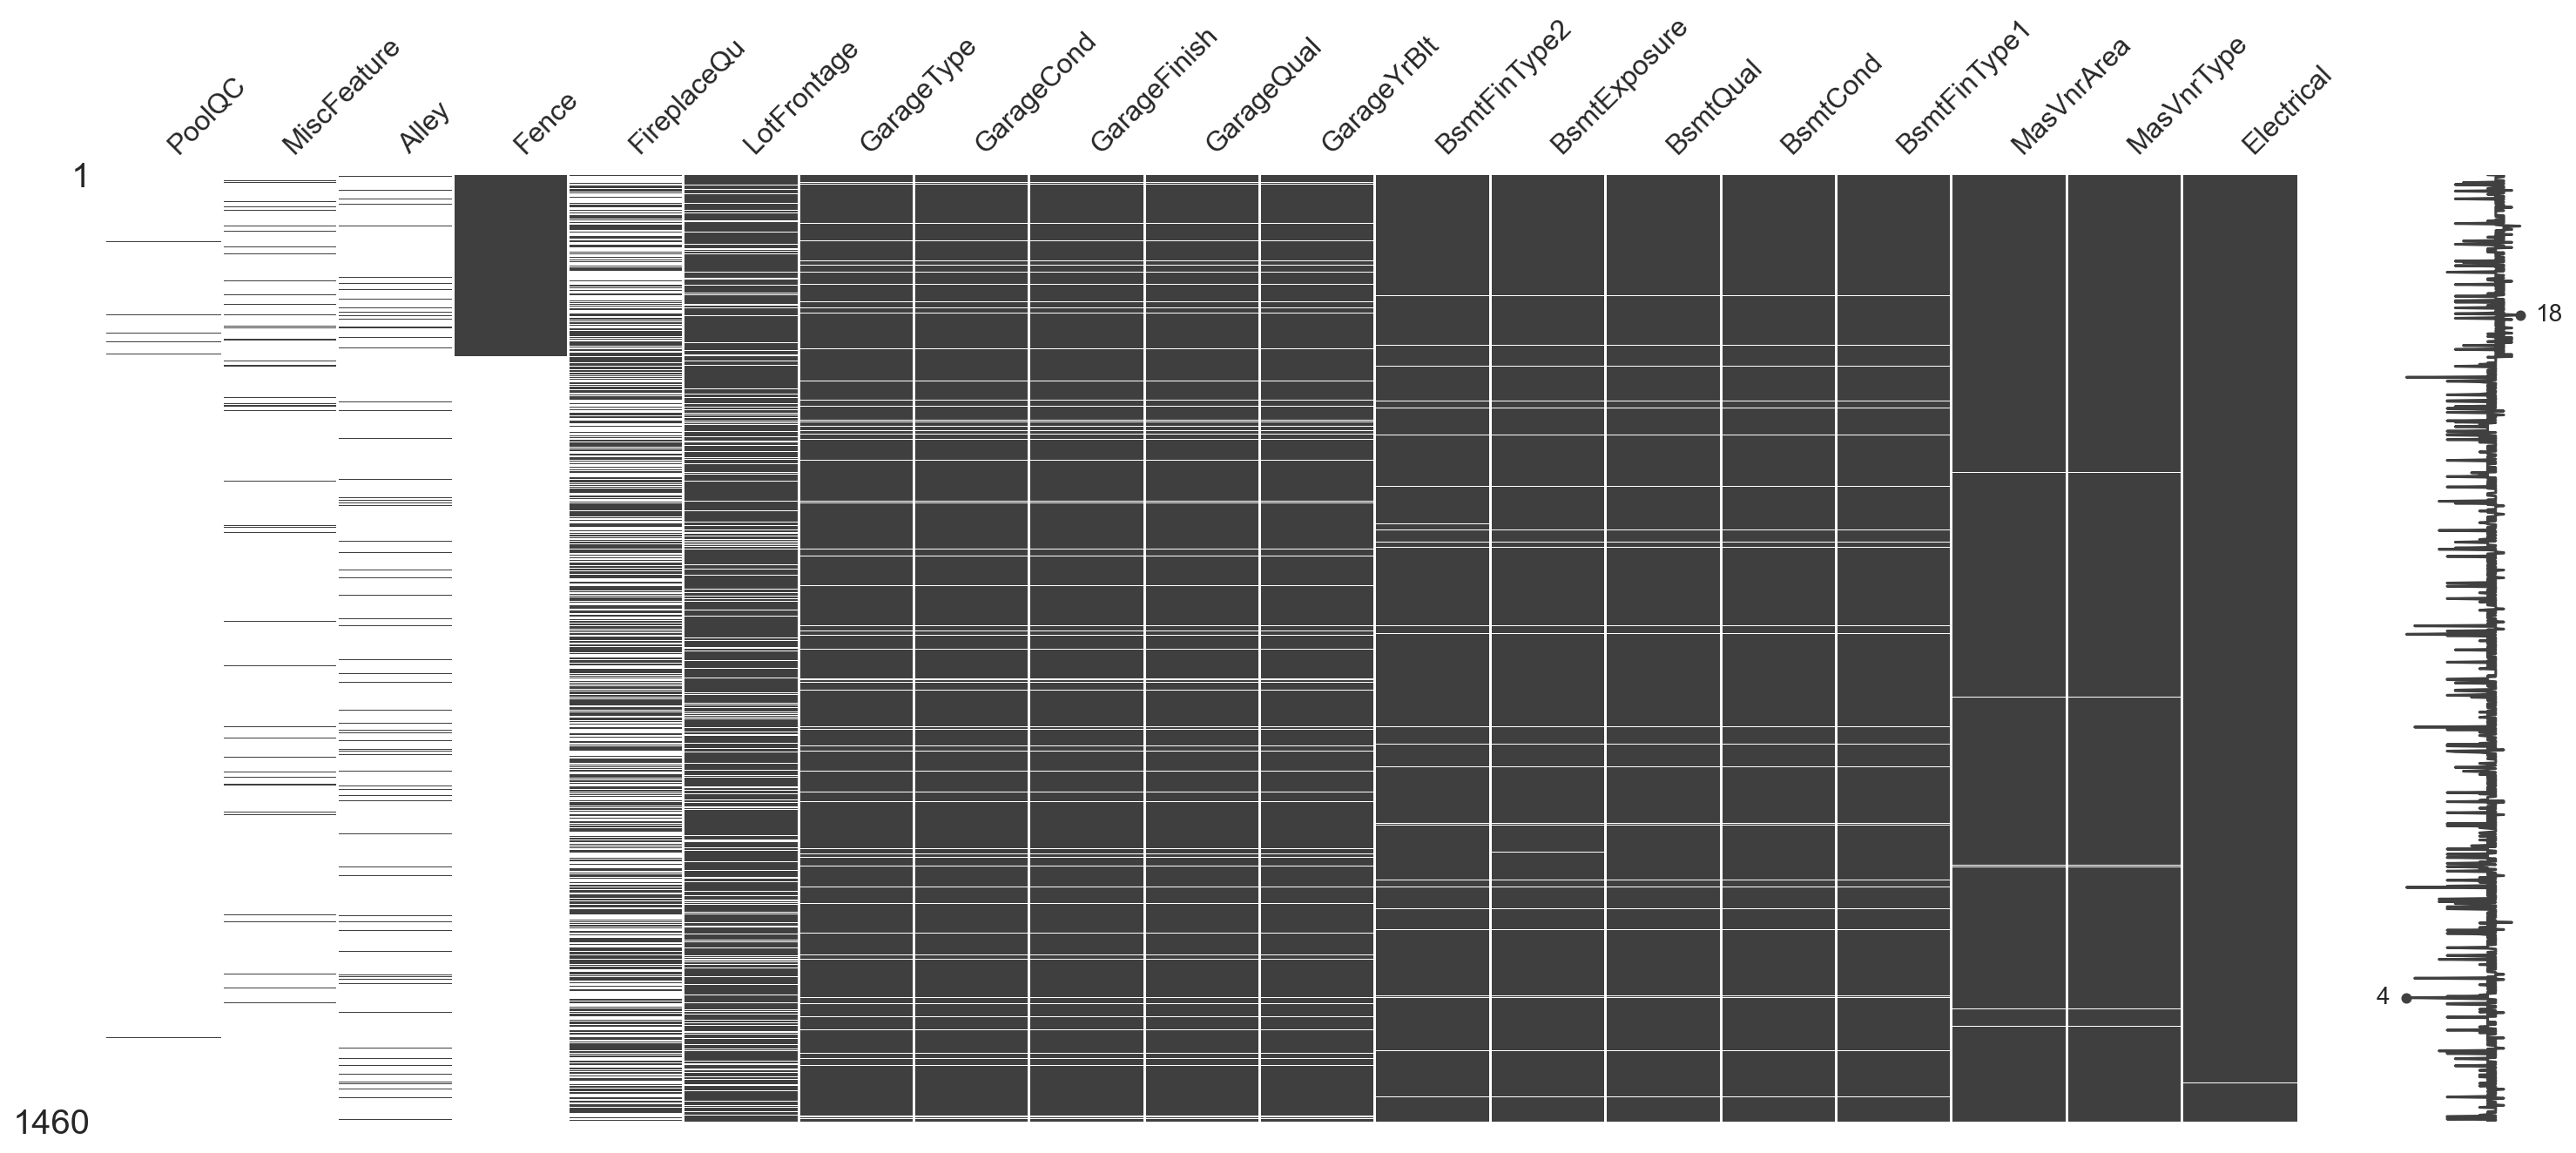

In [7]:
#msno.matrix(df_houses[missing_vals.index].sort_values(by='LotFrontage'))
msno.matrix(df_houses[missing_vals.index].sort_values(by='Fence'));

En la gráfica se aprecia que, como era de esperar, existe relación en la aparición de valores perdidos para tres grupos de columnas: las relativas al garaje, al sótano, y las dos de la mampostrería. También se aprecia el número de valores conocidos para cada fila que oscila entre 4 y 18. 

Otro tipo de gráfica que puede ser interesante en este sentido es un mapa de calor con la correlación de las variables. En este caso se convierten los datos a binarios, indicando si se conoce el valor o no, y se calcula la correlación de estos valores.

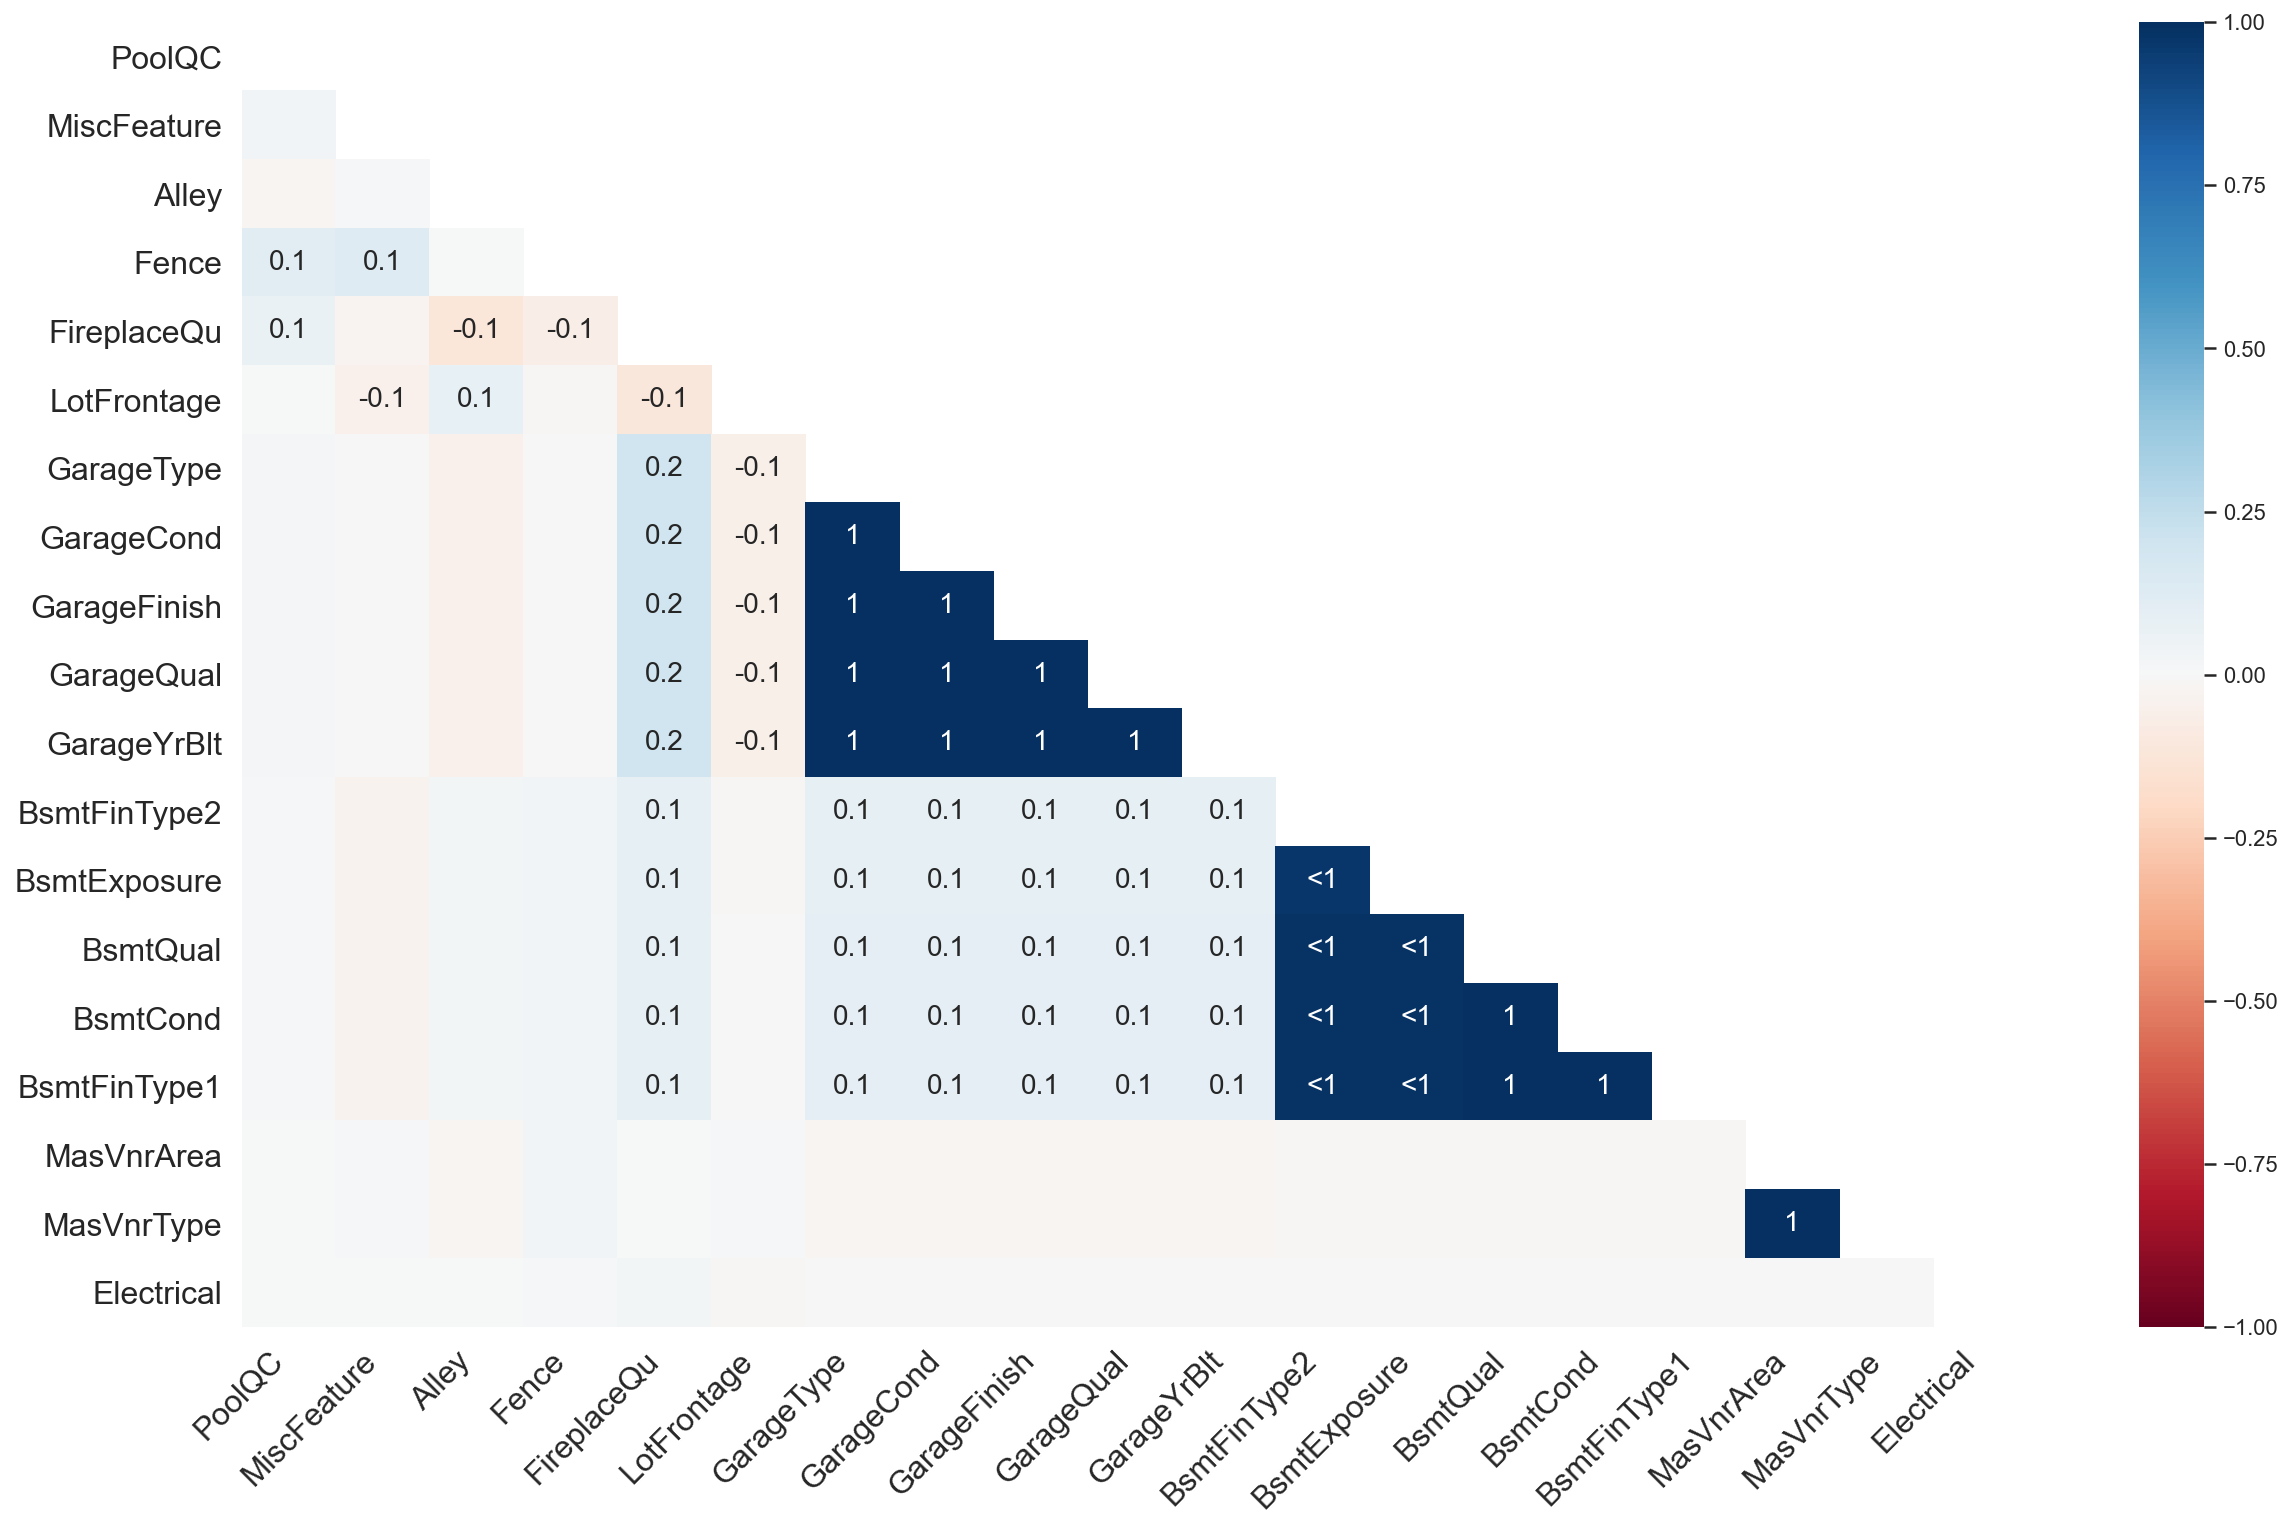

In [8]:
msno.heatmap(df_houses[missing_vals.index]);

Se aprecia lo mismo que en la gráfica anterior. Además, se ve que hay cierta correlación entre la existencia de garaje o sótano. También entre la existencia de extintor en relación con estas dos últimas circunstancias.

Puede apreciarse que existen 19 características para las que existen datos perdidos.  El tratamiento que se  dé a cada una de ellas depende de su categoría. Por ejemplo, en las ordinales, `NA` representa siempre la categoría más baja (según el archivo `data/data_description.txt`). Por tanto, se puede codificar como una categoría más. Como anteriormente se ha asignado el valor $1$ a la categoría más baja, se puede imputar el valor 0.

In [9]:
df_houses[ordinal] = df_houses[ordinal].fillna(0)
df_houses.isna().sum().sort_values(ascending=False).where(lambda n: n>0).dropna()

MiscFeature    1406.0
Alley          1369.0
LotFrontage     259.0
GarageYrBlt      81.0
GarageType       81.0
MasVnrType        8.0
MasVnrArea        8.0
Electrical        1.0
dtype: float64

En el caso de las columnas discretas, `NA` también constituye una categoría que, en general, representa la **inexistencia** de un elemento. 

In [10]:
df_houses[discrete] = df_houses[discrete].fillna('None')
df_houses.isna().sum().sort_values(ascending=False).where(lambda n: n>0).dropna()

LotFrontage    259.0
GarageYrBlt     81.0
MasVnrArea       8.0
dtype: float64

Una vez eliminados estos valores, quedan tres columnas numéricas que contienen valores perdidos. La primera de ellas, `LotFrontage`, es especial, ya que podría representar valores perdidos como tal o que no hay acceso a la calle. La descripción nos muestra que no hay ningún valor igual a cero entre los valores conocidos. 

In [11]:
df_houses['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

Es interesante observar los valores que toman algunas columnas relacionadas en los casos en los que `LotFrontage` es nula. 

In [12]:
df_houses[df_houses['LotFrontage'].isna()][['LotFrontage','LotArea','MSZoning','Street','Alley']].sort_values(by='LotArea', ascending=False)

,LotFrontage,LotArea,MSZoning,Street,Alley
Id,,,,,
336,NaN,164660,RL,Grvl,None
250,NaN,159000,RL,Pave,None
707,NaN,115149,RL,Pave,None
1397,NaN,57200,RL,Pave,None
458,NaN,53227,RL,Pave,None
...,...,...,...,...,...
976,NaN,2651,FV,Pave,None
181,NaN,2117,FV,Pave,None
1359,NaN,2117,FV,Pave,None


No se aprecia nada extraño. También es interesante ver si  alguna vivienda corresponde a terreno agrícola (`MSZoning=A`).

In [13]:
df_houses[df_houses['LotFrontage'].isna()]['MSZoning'].value_counts()

RL    229
RM     19
FV      8
RH      3
Name: MSZoning, dtype: int64

Puede observarse que sí que existen los valores relativos `LotArea` (área del solar) o del tipo de calle. Esto hace pensar que la mejor decisión es imputar el valor perdido. Una estrategia simple es utilizar la mediana de los valores. Sin embargo, podría pensarse que ha de existir cierta correlacion entre el área del solar `LotArea` y la longitud de la fachada que da a la calle `LotFrontage`.

Correlación: 0.43


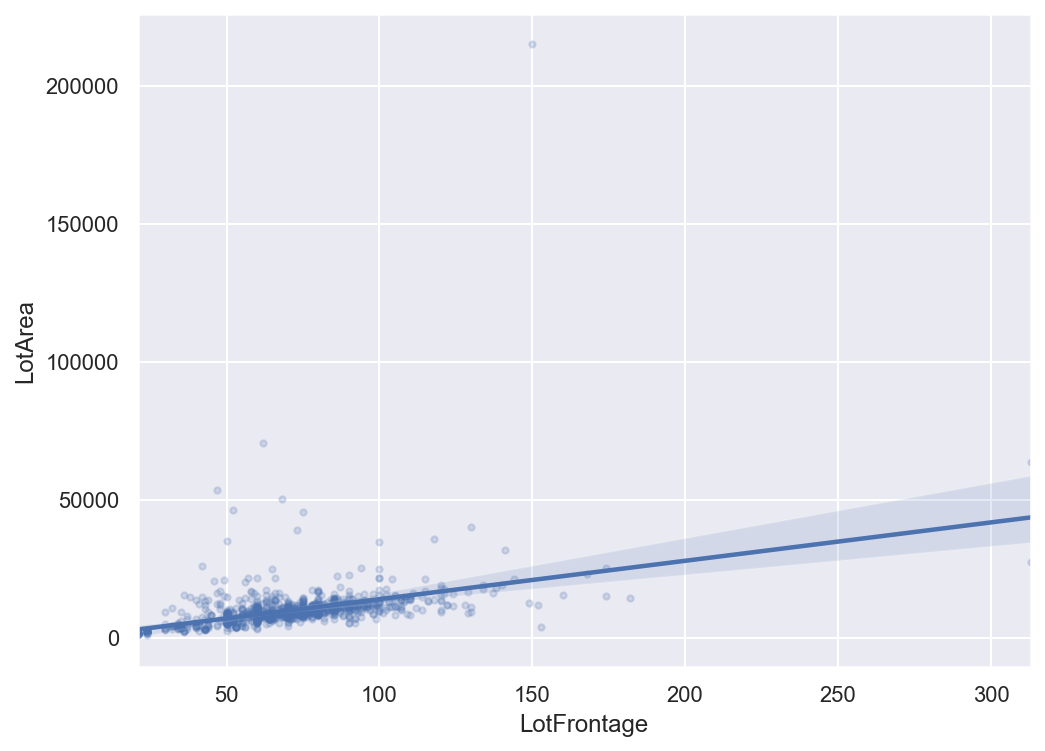

In [14]:
print(f"Correlación: {df_houses['LotFrontage'].corr(df_houses['LotArea']):.2f}")
plt.figure(figsize=(8,6))
sns.regplot(x=df_houses['LotFrontage'], y=df_houses['LotArea'],scatter_kws={'s':10, 'alpha':0.2});

La gráfica muestra que efectivamente, y a pesar de los outliers, existe cierta correlación, aunque no es excesivamente alta (0.43).  Con ánimo de simplificar, y ya que la diferencia no será demasiado sustancial (y no estamos concursando), se podría utilizar la mediana para imputar los valores perdidos. 

In [15]:
#df_houses['LotFrontage'] = df_houses['LotFrontage'].fillna(df_houses['LotFrontage'].median())

<div class="alert alert-block alert-danger">

<i class="fa fa-info-circle" aria-hidden="true"></i> En realidad aquí, estrictramente hablando, podríamos estaríamos en una **fuga de datos**. Dado que se pretende imputar la mediana de todo el atributo antes de realizar el particionamiento en entrenamiento y test, en el pipeline de preparación / aprendizaje se estarían utilizado instancias que solo se pueden utilizar en el momento de la predicción y reporte de resultados.
</div>

La siguiente variable a estudiar es `GarageYrBlt`. El la presencia del valor es informativa, ya que está asociada a la existencia o no de un garaje. Puesto que esa información ya la proporcionan otras dos variables `GarageFinish` y `GarageType`, es conveniente distorsionar los datos lo menos posible. En este caso, podemos imputar el valor mínimo de la columna.

In [16]:
#df_houses['GarageYrBlt'] = df_houses['GarageYrBlt'].fillna(df_houses['GarageYrBlt'].min())

<div class="alert alert-block alert-danger">

<i class="fa fa-info-circle" aria-hidden="true"></i> Estrictamente hablando, aquí también (para calcular el mínimo).
</div>

La última variable, `MasVnrArea` corresponde al área de revestimiento de mampostrería. Un vistazo a los valores perdidos junto con la columna `MasVnrType` proporciona información con respecto a esa característica.

In [17]:
df_houses[df_houses['MasVnrArea'].isna()][['MasVnrArea','MasVnrType']]

,MasVnrArea,MasVnrType
Id,,
235,NaN,None
530,NaN,None
651,NaN,None
937,NaN,None
974,NaN,None
978,NaN,None
1244,NaN,None
1279,NaN,None


Parece que los valores perdidos corresponden a la no existencia de mampostería. Por tanto, se imputará el valor 0.

In [18]:
df_houses['MasVnrArea'] = df_houses['MasVnrArea'].fillna(0)

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
__Importante__: No está mal recordar que hemos trabajado con el conjunto de datos completo porque tenemos información precisa sobre los valores que puede tomar cada variable. En realidad (recordamos), habría que hacer estas transformaciones e imputaciones en un *pipeline* sobre el conjunto de entrenamiento para poder tratar los nuevos datos. Esta opción se plantea como opcional al final, pero hemos decidido plantear el capstone así para simplificar vuestro trabajo.
<br><br>


Hecha esta salvedad,  teniendo en cuenta que asumimos que datos de entrenamiento y test proceden de la misma distribución, que la repercusión de las partes donde hay fuga de datos es mínima, y también con ánimo de simplificar vuestro trabajo, imputaremos los valores de las dos columnas que habíamos dejado para después.
</div>

In [19]:
df_houses['LotFrontage'] = df_houses['LotFrontage'].fillna(df_houses['LotFrontage'].median())
df_houses['GarageYrBlt'] = df_houses['GarageYrBlt'].fillna(df_houses['GarageYrBlt'].min())

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<a id="section3"></a>
## <font color="#00586D"> 3. Exploración preliminar</font>
<br>


Puesto que el objetivo último de este proyecto es la predicción, y el número de variables es alto, la exploración ha de girar entorno a la variable de clase. A continuación se muestra la distribución de la columna `SalePrice`. Se observa que la distribución está sesgada a la izquierda, y que existen valores extremos. Podría ser necesario tener en cuenta esta circunstancia a la hora de elaborar los modelos.

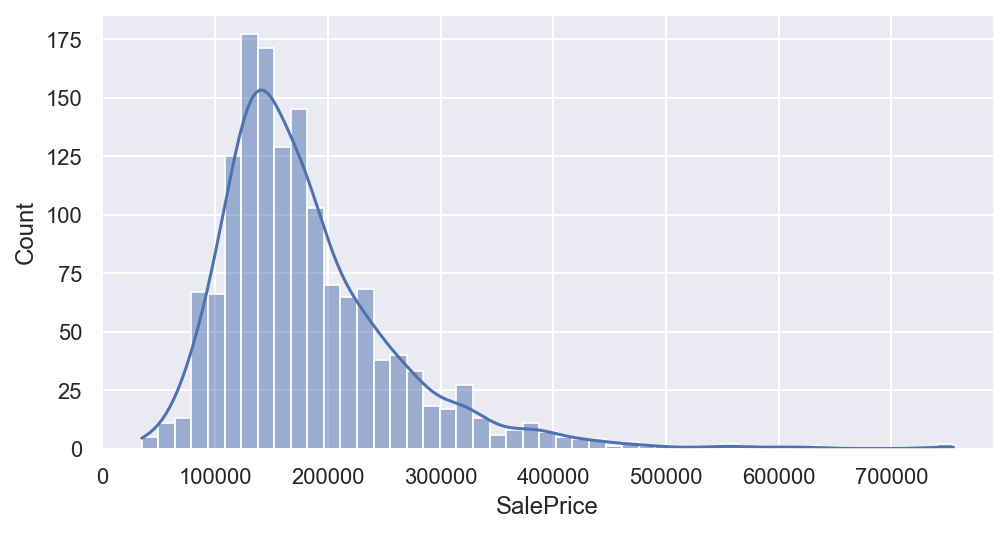

In [20]:
plt.figure(figsize=(8,4))
sns.histplot(x=df_houses['SalePrice'], kde=True);

---

### <font color="#00586D">Exploración sobre variables relacionadas con el precio de la vivienda</font>
<br>

Como el número de variables elevado, y teniendo en cuenta el objetivo, nos detendremos inicialmente en aquellas más correlacionadas (positiva o negativamente) con el precio de venta `SalePrice`. En primer lugar, se explorarán las numéricas y ordinales. 

In [22]:
#(df_houses.corr()['SalePrice']).nlargest(20) # Positiva
(df_houses.corr()['SalePrice']).nsmallest(20) # Negativa

LotShape        -0.267759
Fence           -0.146942
KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
BsmtFinType2    -0.005323
Utilities        0.014314
ExterCond        0.018899
3SsnPorch        0.044584
MoSold           0.046432
LandSlope        0.051152
PoolArea         0.092404
Functional       0.107619
ScreenPorch      0.111447
Name: SalePrice, dtype: float64

Se considerarán, por ejemplo, las 20 con más correlación (positiva o negativa) utilizando el valor absoluto.

In [23]:
relevant_num_feat = (df_houses.corr()['SalePrice']).map(np.abs).nlargest(20)
relevant_num_feat

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
ExterQual       0.682639
KitchenQual     0.659600
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
BsmtQual        0.585207
FullBath        0.560664
GarageFinish    0.549247
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
FireplaceQu     0.520438
GarageYrBlt     0.518287
YearRemodAdd    0.507101
MasVnrArea      0.472614
Fireplaces      0.466929
HeatingQC       0.427649
Name: SalePrice, dtype: float64

Puede observarse que, las correlaciones más fuertes son positivas, y que la correlación está por encima de 0.5 en algunos casos. Se almacenarán sus nombres (excluyendo `SalePrice`) para un *posible* uso posterior.

In [24]:
import pickle

relevant_num_feat = relevant_num_feat[relevant_num_feat>0.5].index.to_list()[1:]#  Deja fuera `SalePrice`
print(relevant_num_feat)

# Guarda la información
with open('data/relevant.pickle', 'wb') as file:
    pickle.dump(relevant_num_feat, file)

['OverallQual', 'GrLivArea', 'ExterQual', 'KitchenQual', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'BsmtQual', 'FullBath', 'GarageFinish', 'TotRmsAbvGrd', 'YearBuilt', 'FireplaceQu', 'GarageYrBlt', 'YearRemodAdd']


A continuación, se exploran las 5 primeras características de `relevant_num_feat` (las más correlacionadas) y `SalePrice` mediante una figura de tipo `PairPlot`. 

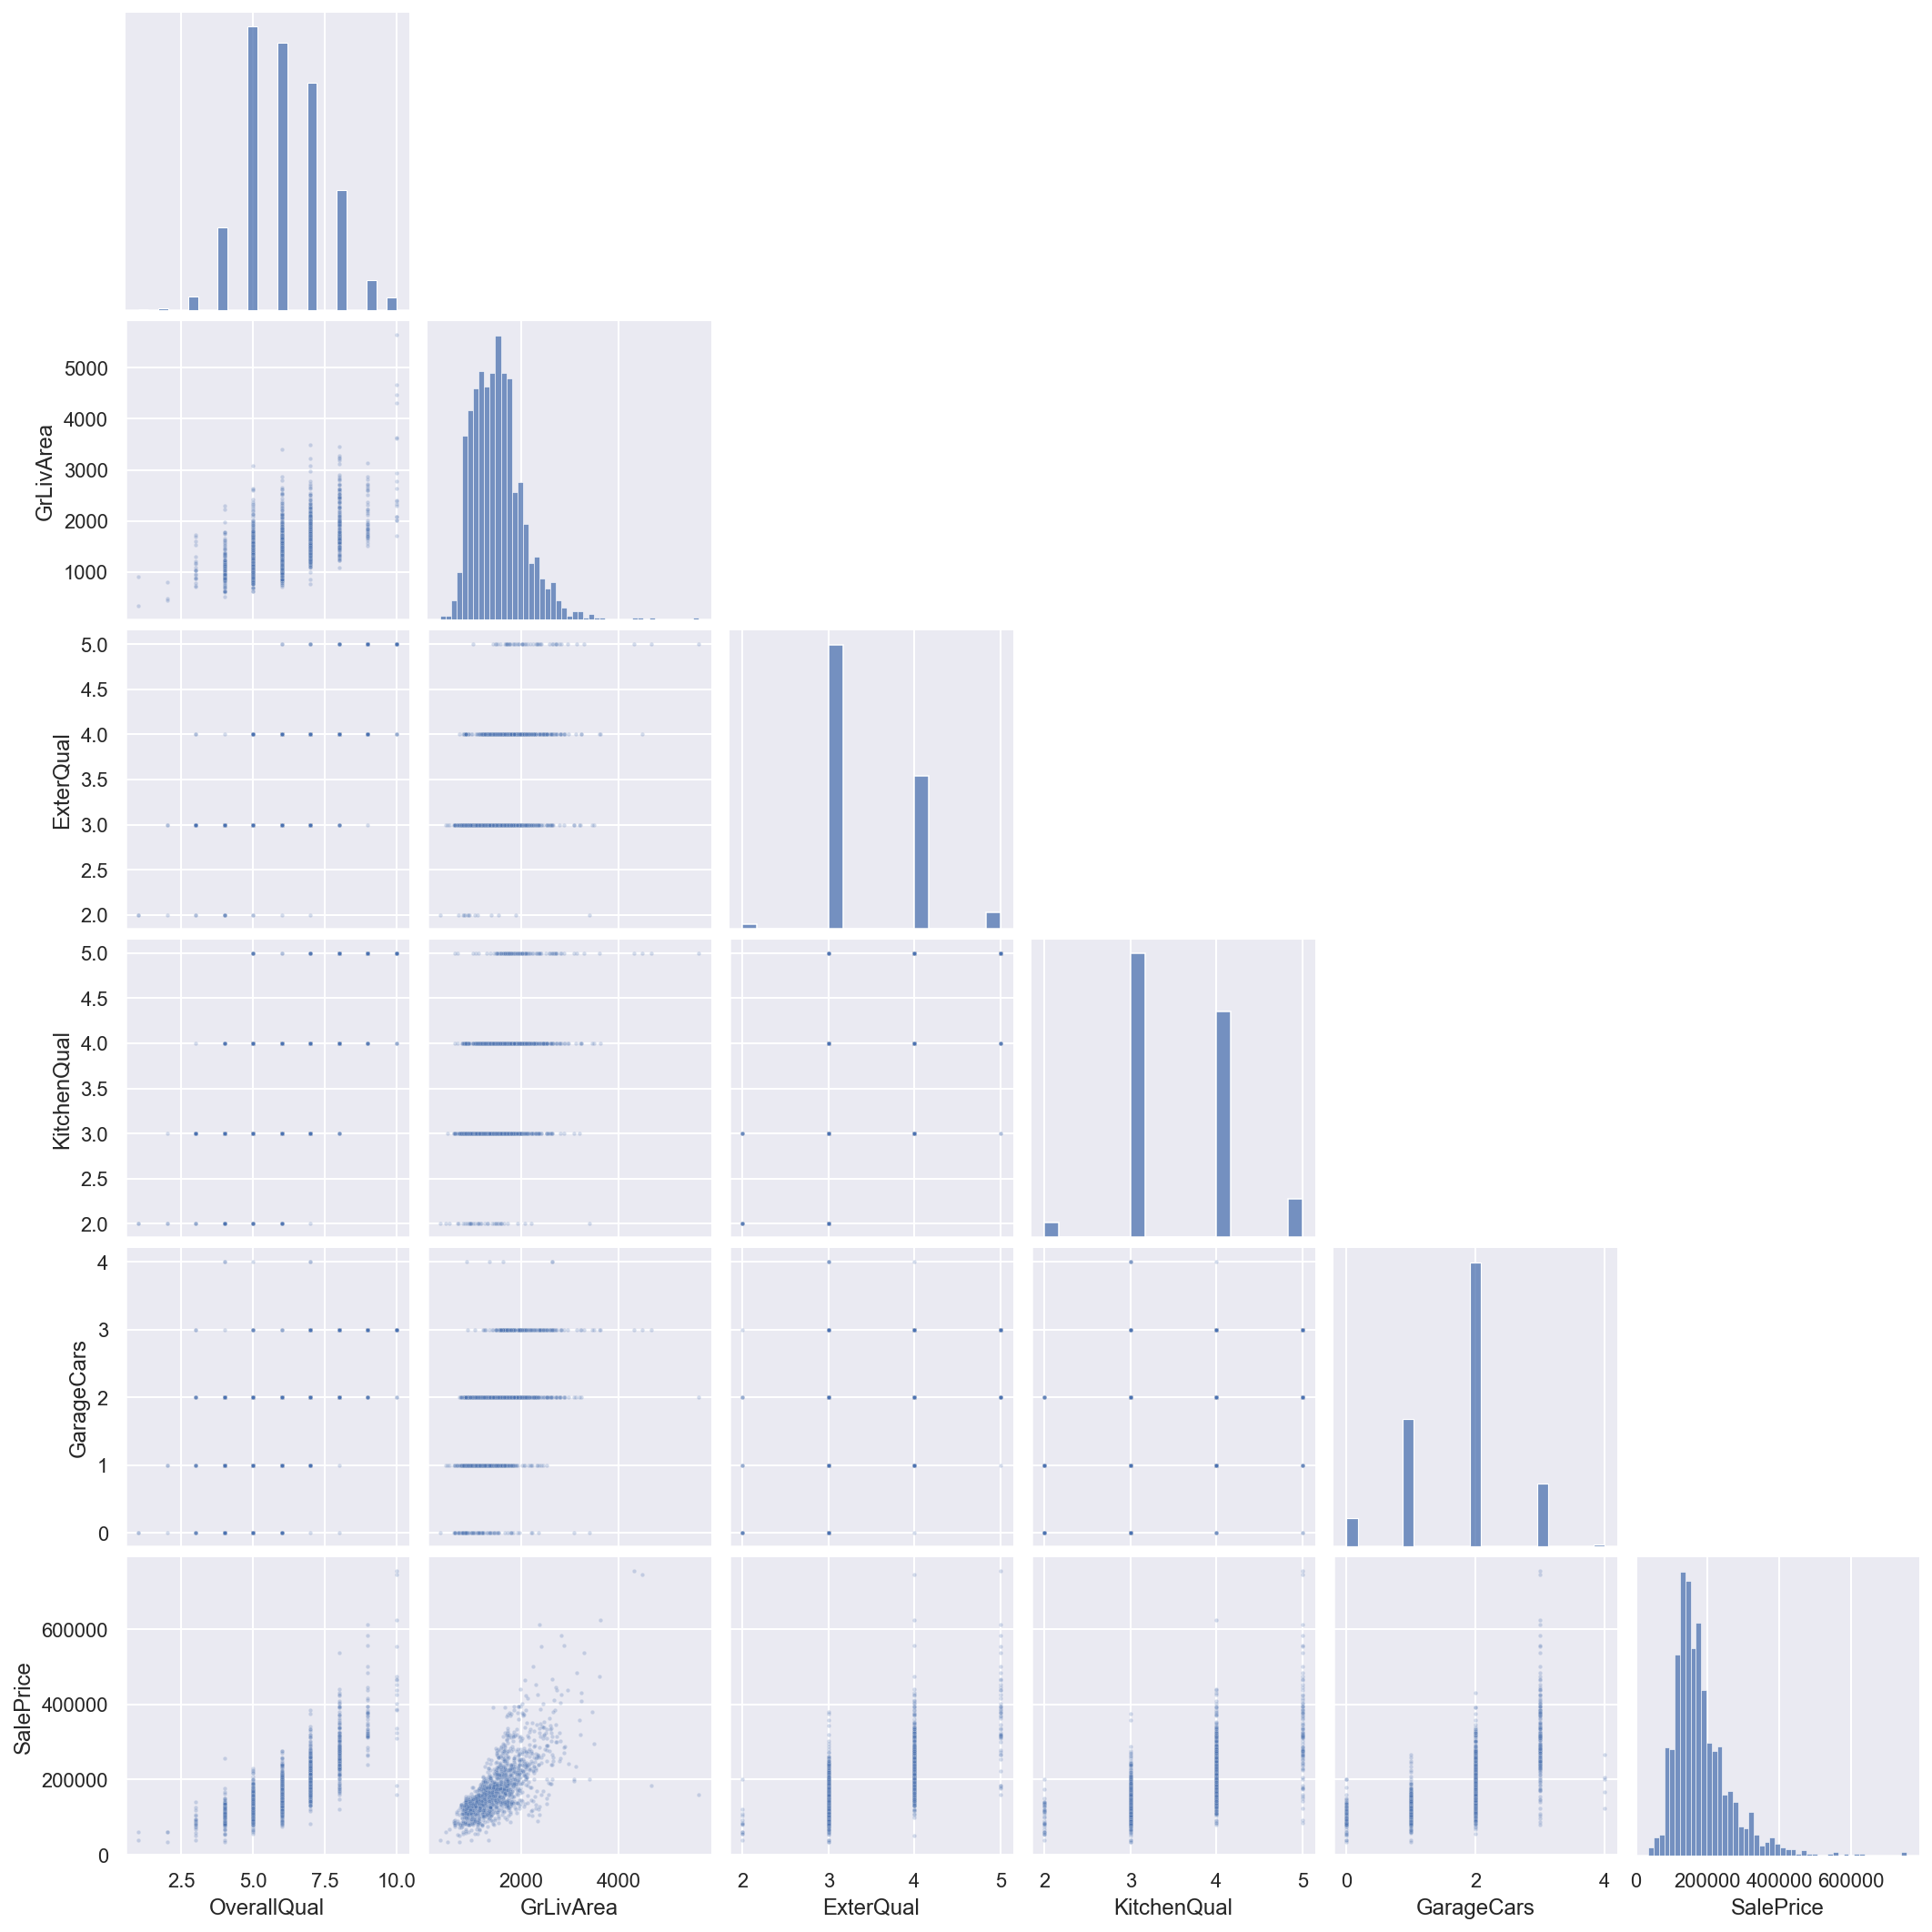

In [25]:
sns.pairplot(df_houses[relevant_num_feat[0:5]+['SalePrice']], corner=True,  plot_kws={'s':5,'alpha':0.25});

En la gráfica se aprecian algunos detalles, además de la correlación que se había obtenido anteriormente. Uno de ellos es que la distribución de valores de `GrLivArea` (el área de la casa sin contar el sótano) también está sesgada (ligeramente). Por otra parte, el valor del precio de venta varía más conforme aumenta el valor de otras variables como `OverallQual` o `GarageCars` (no se da la *homocedasticidad*).

La relación entre `OverallQual` y `SalePrice` *parece que podría no ser*  lineal. La siguiente figura muestra esta relación,  y la relación de `OverallQual` con el logaritmo de `SalePrice`.

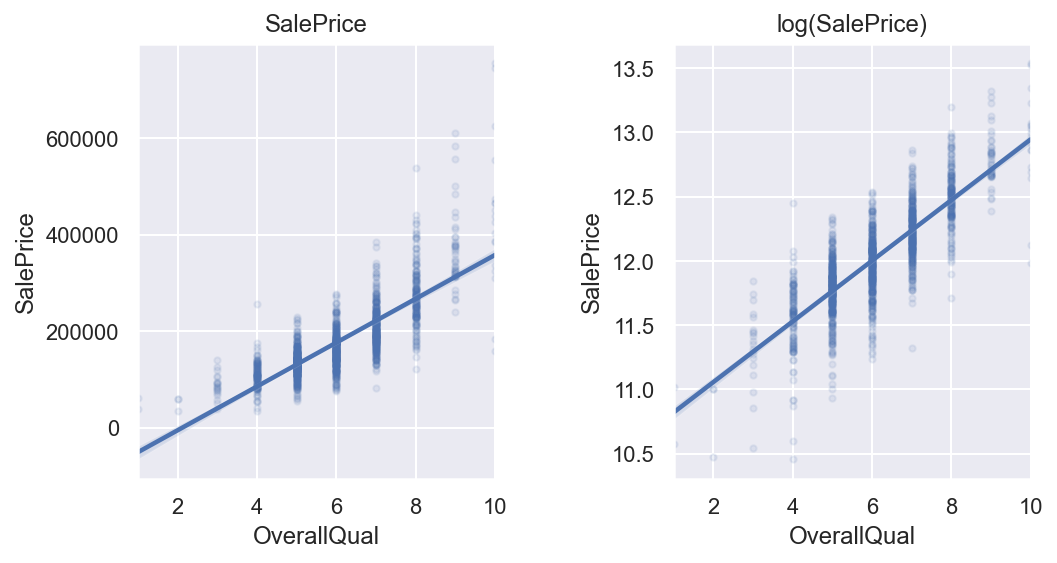

In [26]:
f, axes_grid = plt.subplots(1,2, figsize=(8,4))
sns.regplot(x=df_houses['OverallQual'], y=df_houses['SalePrice'], scatter_kws={'s':10, 'alpha':0.1}, ax = axes_grid[0]);
sns.regplot(x=df_houses['OverallQual'], y=np.log(df_houses['SalePrice']), scatter_kws={'s':10, 'alpha':0.1}, ax = axes_grid[1]);
axes_grid[0].set_title('SalePrice')
axes_grid[1].set_title('log(SalePrice)')
plt.subplots_adjust( wspace=0.5)

Parece que, efectivamente, la segunda gráfica representa mejor la relación, aunque *la diferencia es muy sutil*.

En relación a las variables categóricas, el análisis puede ser más laborioso. A continuación se dibuja un gráfico de cajas para cada una de las variables categóricas con el fin de intuir alguna relación. Para apreciar las tendencias de manera más clara, pueden ordenarse las categorías por la mediana.

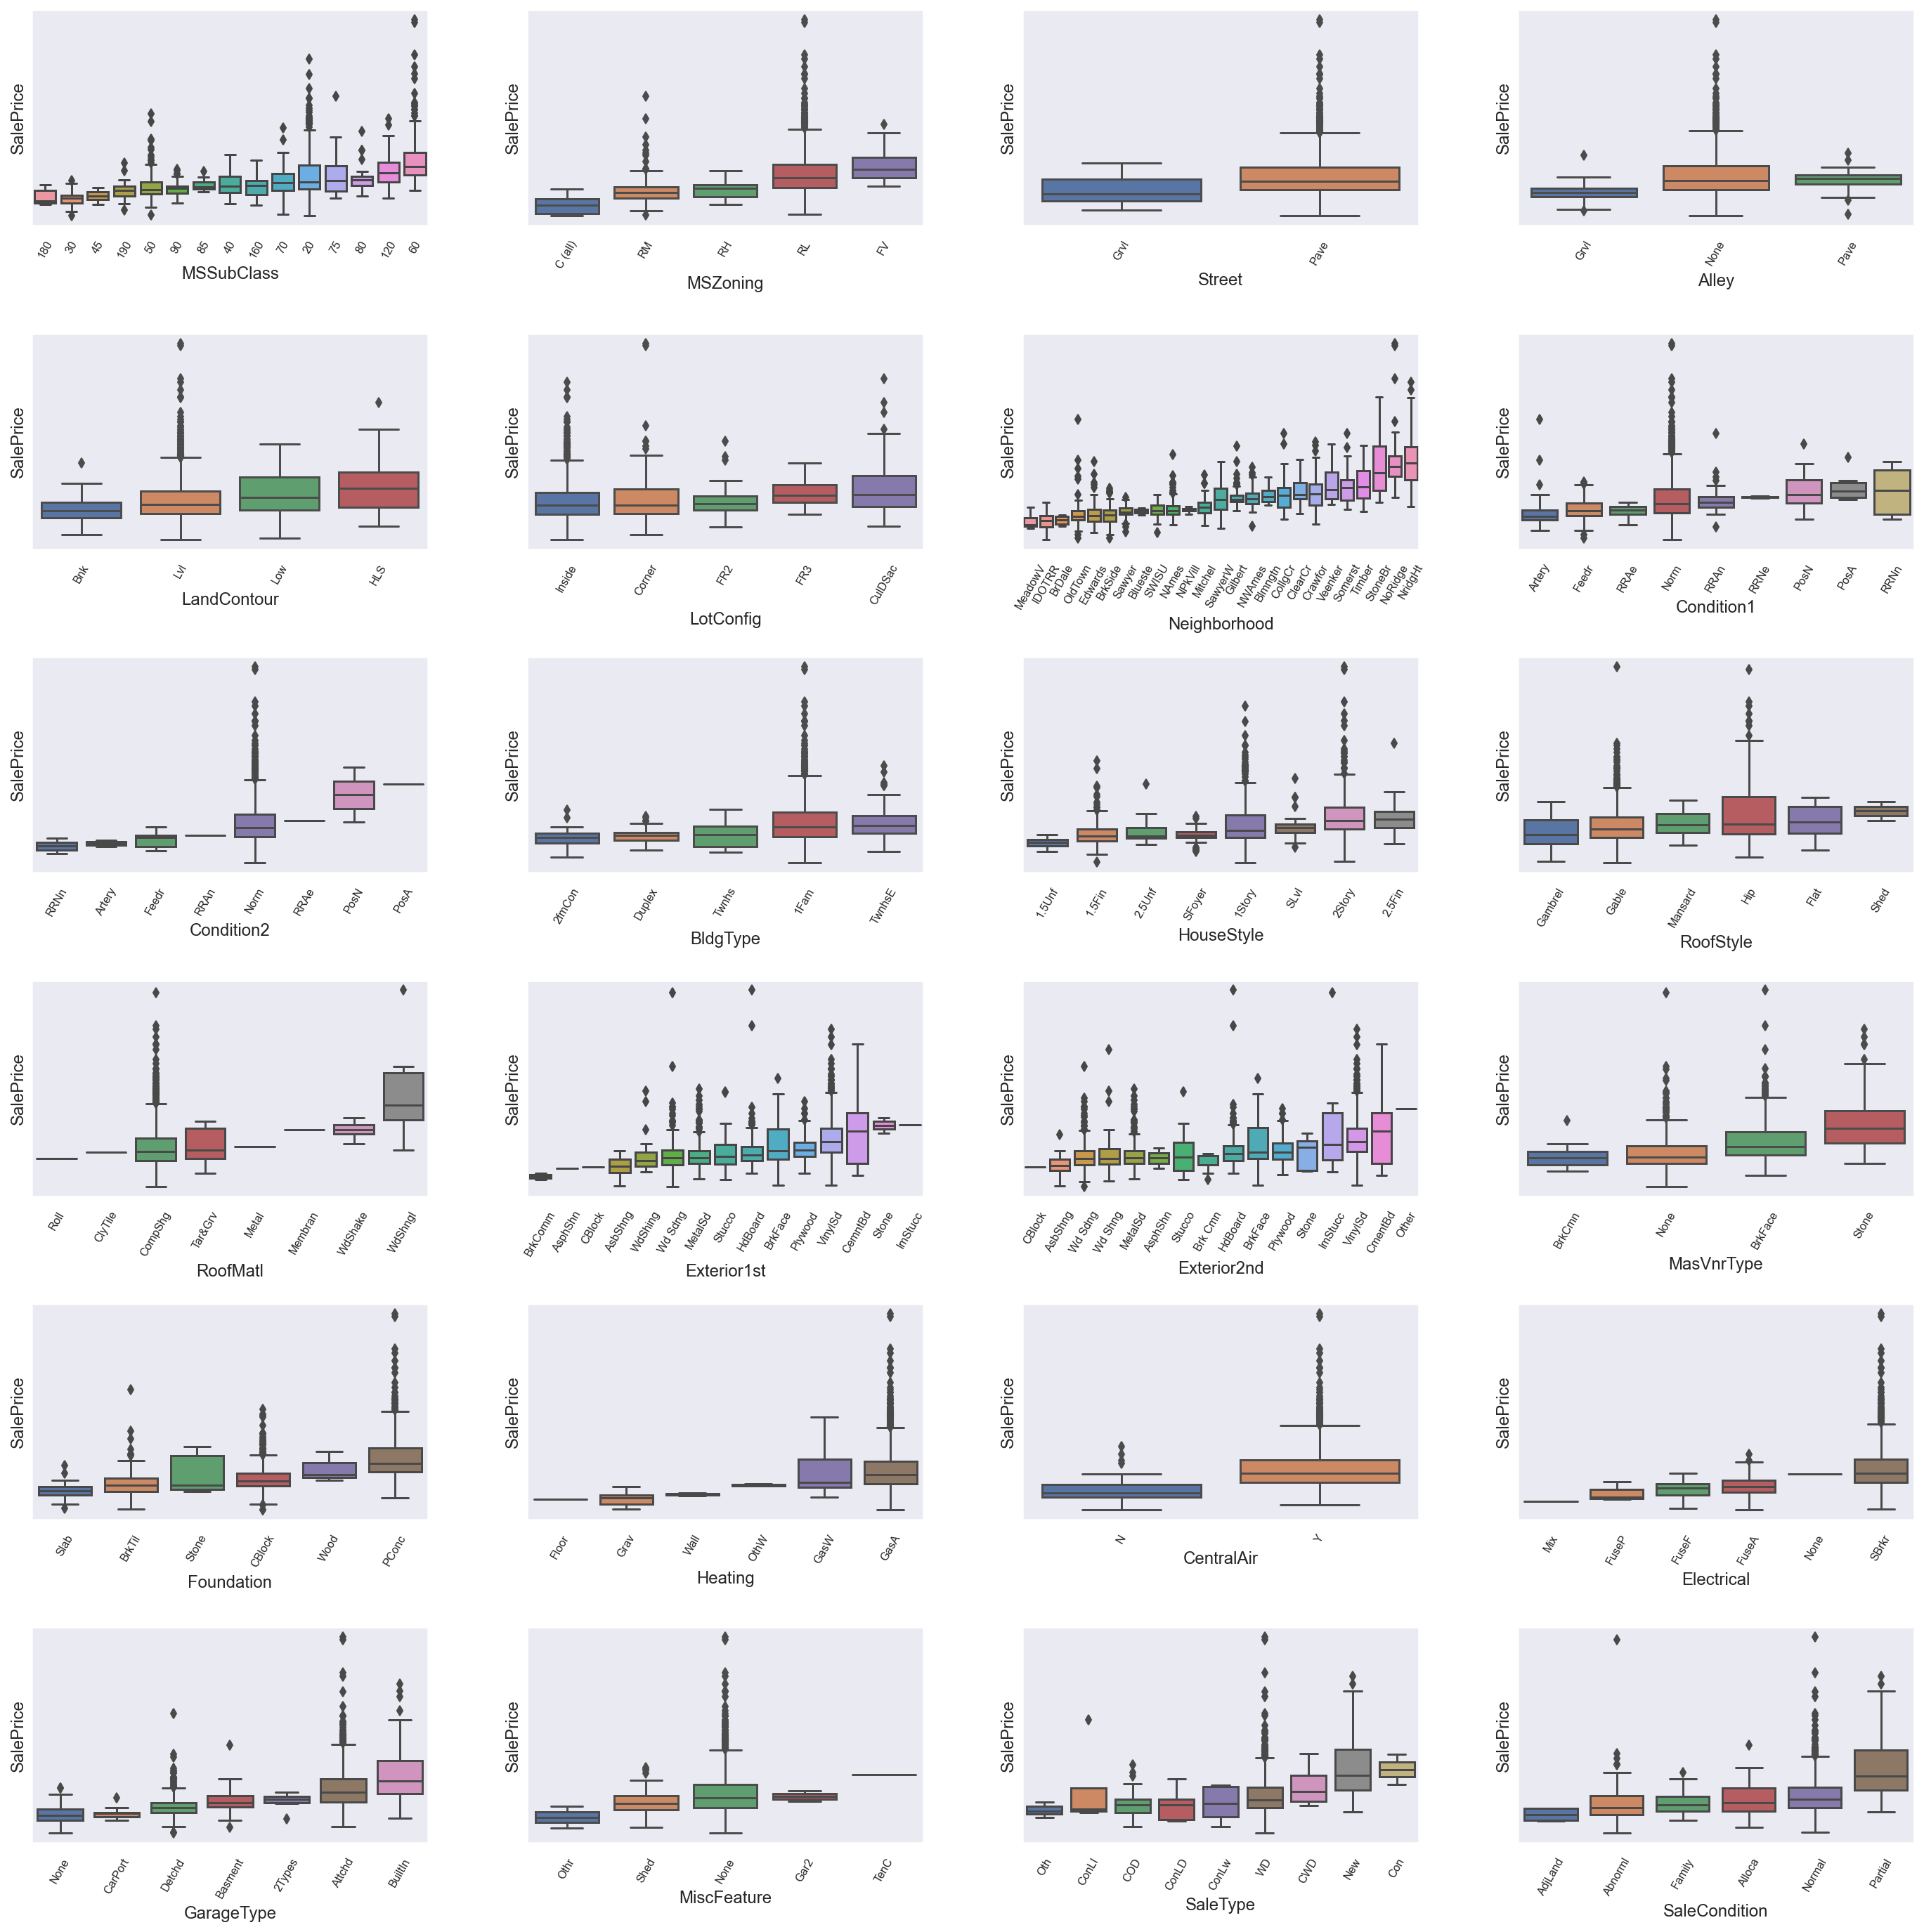

In [27]:
f, axes_grid = plt.subplots(6,4, figsize=(24,24))

for column,ax in zip(discrete,axes_grid.flatten()):
    order = df_houses.groupby(column)['SalePrice'].median().sort_values().index.to_list()
    sns.boxplot(data=df_houses, x=column, y='SalePrice', order=order, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 60, fontsize=8)
    ax.set_yticks([]) 
    
plt.subplots_adjust(hspace=0.5, wspace=0.25)

Aunque la variabilidad no permite apreciar con claridad las tendencias, sí que se aprecia claramente la influencia de la variable discreta en el precio para el caso de características como `Neighborhood`, `LandContour`, `MSZoning` u otras. En otros casos, como `SaleCondition`, no se aprecia diferencia salvo en una de las categorías (`Partial`). 

Otra forma de ver la influencia de las variables discretas con el precio, relacionada también con cómo se codifican en el modelo de aprendizaje, es haciendo una codificación *One Hot* (con pd.get_dummies) y calculando la correlación con `SalePrice`.



In [28]:
pd.concat([pd.get_dummies(df_houses[discrete]), df_houses['SalePrice']], axis=1).corr()['SalePrice'].nlargest(20)

SalePrice                1.000000
Foundation_PConc         0.497734
Neighborhood_NridgHt     0.402149
SaleType_New             0.357509
SaleCondition_Partial    0.352060
GarageType_Attchd        0.335961
MasVnrType_Stone         0.330476
Neighborhood_NoRidge     0.330424
Exterior2nd_VinylSd      0.306389
Exterior1st_VinylSd      0.305009
CentralAir_Y             0.251328
MSZoning_RL              0.245063
HouseStyle_2Story        0.242880
Electrical_SBrkr         0.241896
RoofStyle_Hip            0.235897
GarageType_BuiltIn       0.235449
Neighborhood_StoneBr     0.215363
MasVnrType_BrkFace       0.198191
RoofMatl_WdShngl         0.169324
LotConfig_CulDSac        0.141818
Name: SalePrice, dtype: float64

En este caso se ve que la correlación positiva corresponde a algunos valores, como la base de cemento (`Foundation_PConc`), un vecindario concreto (`Neighborhood_NridgHt`) o el tipo de venta (`SaleType_New`). No obstante, estas correlaciones no son excesivamente relevantes. Se pueden obtener también las que repercuten negativamente.

In [29]:
pd.concat([pd.get_dummies(df_houses[discrete]), df_houses['SalePrice']], axis=1).corr()['SalePrice'].nsmallest(20)

MasVnrType_None        -0.367456
GarageType_Detchd      -0.354141
Foundation_CBlock      -0.343263
MSZoning_RM            -0.288065
CentralAir_N           -0.251328
SaleType_WD            -0.242598
GarageType_None        -0.236832
RoofStyle_Gable        -0.224744
Foundation_BrkTil      -0.204117
Electrical_FuseA       -0.193978
Neighborhood_OldTown   -0.192189
Neighborhood_NAmes     -0.188513
Neighborhood_Edwards   -0.179949
Exterior1st_MetalSd    -0.167068
Neighborhood_IDOTRR    -0.164056
HouseStyle_1.5Fin      -0.163466
Exterior2nd_MetalSd    -0.162389
Exterior2nd_Wd Sdng    -0.161800
Exterior1st_Wd Sdng    -0.158619
SaleCondition_Normal   -0.153990
Name: SalePrice, dtype: float64

La ausencia de mampostrería (`MasVnrType_None`), el garaje separado (`GarageType_Detchd`), o algunos vecindarios repercuten negativamente en el precio de la vivienda.

Como el número de variables binarias es muy elevado en relación al conjunto de datos, y se corre el riesgo de sobreajustar, nos quedaremos con las más relevantes (positiva o negativamente) y se almacenarán en `relevant_dum_feat` por si hubiese que utilizar esta información en algunas en fases posteriores.

In [30]:
relevant_dum_feat = (pd.concat([pd.get_dummies(df_houses[discrete]), df_houses['SalePrice']], axis=1)
                   .corr()['SalePrice']
                   .apply(np.abs)
                   .nlargest(20)).index.to_list()[1:]

print(relevant_dum_feat)

# Guarda la información
with open('data/relevant_oh.pickle', 'wb') as file:
    pickle.dump(relevant_dum_feat, file)

['Foundation_PConc', 'Neighborhood_NridgHt', 'MasVnrType_None', 'SaleType_New', 'GarageType_Detchd', 'SaleCondition_Partial', 'Foundation_CBlock', 'GarageType_Attchd', 'MasVnrType_Stone', 'Neighborhood_NoRidge', 'Exterior2nd_VinylSd', 'Exterior1st_VinylSd', 'MSZoning_RM', 'CentralAir_Y', 'CentralAir_N', 'MSZoning_RL', 'HouseStyle_2Story', 'SaleType_WD', 'Electrical_SBrkr']


Para terminar se creará un conjunto de datos. La única transformación que se ha de hacer es la correspondiente a las variables discretas, para las que hay que hacer una transformación *One Hot*. El conjunto de datos resultante se almacenará en el archivo `data/houses_prep.csv`.

In [31]:
data = pd.concat([df_houses[numerical+ordinal], pd.get_dummies(df_houses[discrete])], axis=1).copy()
data.to_csv('data/houses_prep.csv')

<div align="right">
<a href="#indice"><font size=5 color="#00586D"><i class="fa fa-arrow-circle-up" aria-hidden="true"></i></font></a>
</div>

---

<div align="right">
<a href="#indice"><font size=6 color="#00586D"><i class="fa fa-coffee" aria-hidden="true"></i></font></a>
</div>